## Figures 2, 3, 5, 6, 7 and summary statistics from Fishbach & van Son (2023)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import seaborn as sns

import numpy as np

from scipy.integrate import cumtrapz

import jax.numpy as jnp

import h5py

import astropy.cosmology as cosmo
import astropy.units as u
import astropy.constants as const

import delay_time_helper #included in repo

### Plotting and summary statistics helper functions

In [2]:
sns.set_palette('colorblind')

sns.set_context('paper', font_scale = 1.5)
sns.color_palette('colorblind')
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

def median_pm_symmetric(post, low = 5, high = 95):
    '''
    Inputs: post (array), low (float between 0-100), high (float between 0-100)
    Given posterior post, return median plus/minus symmetric credible bounds spanning "low" percentile to "high" percentile
    Returns: string
    '''
    x = np.median(post)
    p = np.percentile(post, high) - x
    m = x - np.percentile(post, low)
    s = '%.1f^{+%.1f}_{-%.1f}'%(x, p, m)
    return s


def plot_bands(ax, xs, lines, bounds = [(5, 95), (25,75)], color = sns.color_palette()[0], alpha = 0.3, plot_kwargs = {}):
    '''
    Inputs:
        ax: plotting axis
        xs: x-axis values
        lines: shape (# of samples, len(xs))
        bounds (optional): list of tuples specifying percentiles bounding filled bands
        color (optional): color to plot
        alpha (optional): alpha of filled bands
        plot_kwargs (optional): dict containing key word arguments to pass to pyplot, e.g. label, linewidth
    '''

    ax.plot(xs, np.percentile(lines, 50, axis = 0), color = color,  **plot_kwargs)
    for b in bounds:
        ax.fill_between(xs, np.percentile(lines, b[0], axis = 0), np.percentile(lines, b[1], axis = 0), alpha = alpha, color = color)


def plot_cdf_bands(ax, samps, bounds = [(5, 95), (25,75)], color = sns.color_palette()[0], alpha = 0.3, filled = True, lss = ['-.', ':'],  plot_kwargs = {}, ret_lines = False):
    '''
    Inputs:
        ax: plotting axis
        samps: array with shape (# of hyper-samples, # of events per hyper-sample), e.g. obs_samps_allparams["redshift"]
        bounds (optional): list of tuples specifying percentiles bounding filled bands
        color (optional): color to plot
        alpha (optional): alpha of filled bands
        filled (optional): if True, fill the bands, if not, return unfilled bands
        lss (optional): linestyles to use for bands if filled = False
        plot_kwargs (optional): dict containing key word arguments to pass to pyplot, e.g. label, linewidth
        ret_lines (optional): if True, returns array of same shape as samps containing sorted draws for each hyper-sample
    '''

    lines = np.zeros_like(samps)

    nhyper = samps.shape[0]
    nevents = samps.shape[-1]

    for i in range(nhyper):
        sorter = np.argsort(samps[i,:])
        lines[i,:] = samps[i,:][sorter]

    ys = (1+np.arange(nevents))/nevents

    ax.plot(np.percentile(lines, 50, axis = 0), ys, color = color, **plot_kwargs)

    for i, b in enumerate(bounds):

        if filled:
            ax.fill_betweenx(ys, np.percentile(lines, b[0], axis = 0), np.percentile(lines, b[1], axis = 0), alpha = alpha, color = color)

        else:
            ax.fill_betweenx(ys, np.percentile(lines, b[0], axis = 0), np.percentile(lines, b[1], axis = 0), ls = lss[i], edgecolor = color, facecolor = 'none')

    if ret_lines:
        return lines

### Interpolate cosmological functions

In [3]:
zmin = 0.0
zmax = 20.0
zres = 0.01
dist_unit = u.Mpc
time_unit = u.Myr

def interp_cosmo_func(func, unit = None, zmin = 0.0, zmax = 5.0, zres = 0.01, f = 1.0):
    '''for a given astropy.cosmology func of z, return jax.numpy interpolant of the function and its inverse'''
    nz = int(round((zmax-zmin)/zres)) 
    zs = np.linspace(zmin,zmax,nz)
    if unit:
        y = f * func(zs).to(unit).value
    else:
        y = f * func(zs)
    return lambda x : jnp.interp(x, zs, y), lambda x: jnp.interp(x, y, zs)

def interp_cosmology(zmin = 0.0, zmax = 5.0, zres = 0.01, cos = cosmo.Planck15, dist_unit = u.Mpc, time_unit = u.Myr):
    funcs = [cos.luminosity_distance, cos.comoving_distance, cos.inv_efunc, cos.differential_comoving_volume, cos.lookback_time]
    units = [dist_unit, dist_unit, None, dist_unit**3/u.sr, time_unit]
    fs = [1, 1, 1, 4.0*jnp.pi, 1]
    out = dict()
    out['dist_Mpc'] = dist_unit.to(u.Mpc)
    out['time_Myr'] = time_unit.to(u.Myr)
    out['H0'] = cos.H0.to(u.kilometer/u.second/u.Mpc).value
    out['hubble_distance'] = cos.hubble_distance.to(dist_unit).value
    out['hubble_time'] = cos.hubble_time.to(time_unit).value
    out['age_of_universe'] = cos.age(0).to(time_unit).value
    for i, func in enumerate(funcs):
        name = func.__name__
        f_interp, f_inv_interp = interp_cosmo_func(func, unit = units[i], zmin = zmin, zmax = zmax, zres = zres, f = fs[i])
        out[name] = f_interp
        out["z_at_"+name] = f_inv_interp
    return out

cosmo_dict = interp_cosmology(zmin = zmin, zmax = zmax, zres = zres, cos = cosmo.Planck15, dist_unit = dist_unit, time_unit = time_unit)

In [4]:
tmax = cosmo_dict["lookback_time"](zmax)
print(tmax/1e3)

13.619099


In [5]:
seed = 1148

In [6]:
color_dict = {'default' : sns.color_palette()[2], 'shallower' : sns.color_palette()[0], 'shallow' : sns.color_palette()[3],
             'prior' : sns.color_palette()[1], 'merger' : sns.color_palette()[7]
             }

### Read in data files

In [7]:
tmin = 10

alpha = -1
with h5py.File(f"formation_rate_hypersamples_plusgrid_tmin{tmin}_al{-alpha}.h5", 'r') as inp:
    Rfs = np.array(inp["Rf_posterior"])
    Rfs_prior = np.array(inp["Rf_prior"])
    tL_forms = np.array(inp["tL_forms"])
    loglikes = np.array(inp["hypersamples/log_likelihood"])
    
    reweighted_PE_al01 = {}
    for key in inp["reweighted_PE"].keys():
        reweighted_PE_al01[key] = np.array(inp["reweighted_PE"][key])
        
    reweighted_inj_al01 = {}
    for key in inp["reweighted_inj"].keys():
        reweighted_inj_al01[key] = np.array(inp["reweighted_inj"][key])
    

alpha = -0.35
with h5py.File(f"formation_rate_hypersamples_plusgrid_tmin{tmin}_al{-alpha}.h5", 'r') as inp:
    Rfs_al035 = np.array(inp["Rf_posterior"])
    Rfs_prior_al035 = np.array(inp["Rf_prior"])
    loglikes_al035 = np.array(inp["hypersamples/log_likelihood"])
    
    reweighted_PE_al035 = {}
    for key in inp["reweighted_PE"].keys():
        reweighted_PE_al035[key] = np.array(inp["reweighted_PE"][key])
        
    reweighted_inj_al035 = {}
    for key in inp["reweighted_inj"].keys():
        reweighted_inj_al035[key] = np.array(inp["reweighted_inj"][key])

alpha = -0.7
with h5py.File(f"formation_rate_hypersamples_plusgrid_tmin{tmin}_al{-alpha}.h5", 'r') as inp:
    Rfs_al07 = np.array(inp["Rf_posterior"])
    Rfs_prior_al07 = np.array(inp["Rf_prior"])
    loglikes_al07 = np.array(inp["hypersamples/log_likelihood"])
    
    reweighted_PE_al07 = {}
    for key in inp["reweighted_PE"].keys():
        reweighted_PE_al07[key] = np.array(inp["reweighted_PE"][key])
        
    reweighted_inj_al07 = {}
    for key in inp["reweighted_inj"].keys():
        reweighted_inj_al07[key] = np.array(inp["reweighted_inj"][key])
    
#keys for reweighted PE dictionaries are ['chi_eff', 'formation_lookback_time', 'mass_1_source', 'mass_2_source', 'redshift']


### Figure 7: joint z_merge, z_form of GWTC-3 events

In [8]:
zs_m = jnp.linspace(0.01, 2, 50)

zs_f_90 = np.zeros((len(zs_m), 500))
zs_f_99 = np.zeros((len(zs_m), 500))
zs_f_999 = np.zeros((len(zs_m), 500))

for i in range(500):
    zs_f_90[:,i] = delay_time_helper.calculate_zf_quantiles_from_zm(zs_m, q = 0.9, tmin = 10, alpha = -1, tmax = tmax, Rf_func = lambda x: np.interp(x, tL_forms, Rfs[i,:]))
    zs_f_99[:,i] = delay_time_helper.calculate_zf_quantiles_from_zm(zs_m, q = 0.99, tmin = 10, alpha = -1, tmax = tmax, Rf_func = lambda x: np.interp(x, tL_forms, Rfs[i,:]))
    zs_f_999[:,i] = delay_time_helper.calculate_zf_quantiles_from_zm(zs_m, q = 0.999, tmin = 10, alpha = -1, tmax = tmax, Rf_func = lambda x: np.interp(x, tL_forms, Rfs[i,:]))


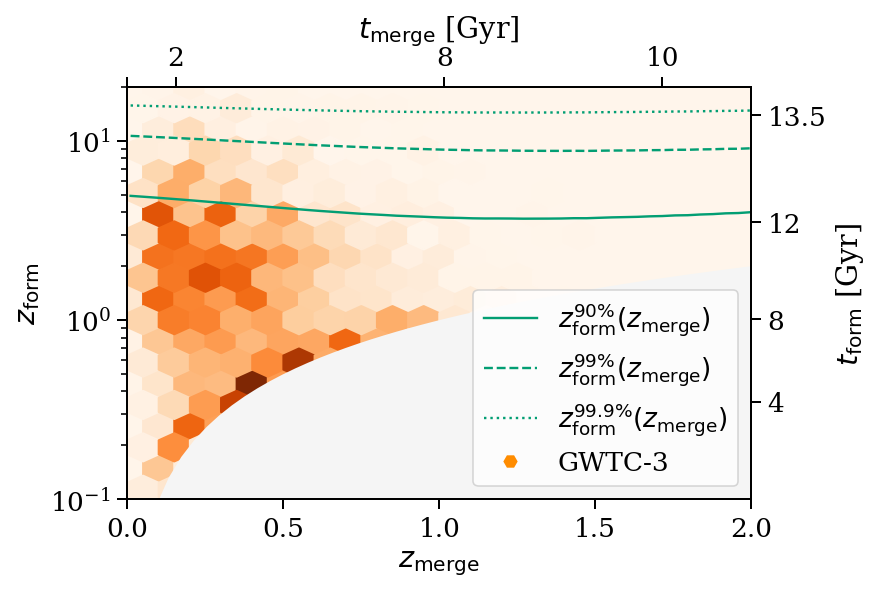

In [10]:
fig, ax = plt.subplots(constrained_layout = True)


ax.hexbin(reweighted_inj_al01["redshift"].flatten(), cosmo_dict["z_at_lookback_time"](reweighted_inj_al01["formation_lookback_time"].flatten()), 
           yscale = 'log', extent = (0, 2, np.log10(0.05), np.log10(20)), gridsize = 20, cmap = "Oranges")

ax.plot(zs_m, np.mean((zs_f_90), axis = -1), c = color_dict["default"], label = r'$z^{90\%}_\mathrm{form}(z_\mathrm{merge})$')
ax.plot(zs_m, np.mean((zs_f_99), axis = -1), ls = '--', c = color_dict["default"], label = r'$z^{99\%}_\mathrm{form}(z_\mathrm{merge})$')
ax.plot(zs_m, np.mean((zs_f_999), axis = -1), ls = ':', c = color_dict["default"], label = r'$z^{99.9\%}_\mathrm{form}(z_\mathrm{merge})$')

ax.plot(30,30, c = 'darkorange', marker = 'H', linestyle = "None", markersize = 6, label = 'GWTC-3')


ax.fill_between(zs_m, zs_m, facecolor = 'whitesmoke')

ax.set_xlim(0, 2)
ax.set_ylim(0.1, 20)

ax.set_xlabel(r'$z_\mathrm{merge}$')
ax.set_ylabel(r'$z_\mathrm{form}$')

plt.legend(loc = 'lower right', frameon = True)

timeax = ax.secondary_xaxis('top', functions=(cosmo_dict["lookback_time"],cosmo_dict["z_at_lookback_time"]))
timeax.set_xticks(ticks = [0, 2000, 8000, 10000], labels = ['', '2', '8', '10'])
timeax.set_xlabel(r'$t_\mathrm{merge}$ [Gyr]')

timeax1 = ax.secondary_yaxis('right', functions=(cosmo_dict["lookback_time"], cosmo_dict["z_at_lookback_time"]))
timeax1.set_yticks(ticks = [4000, 8000, 12000, 13500], labels = ['4', '8', '12', '13.5'])
timeax1.yaxis.set_tick_params(which='minor', right=False) #turn off minor tick labels
timeax1.set_ylabel(r'$t_\mathrm{form}$ [Gyr]')


#plt.savefig("figures/zform_vs_zmerge_GWTC3.pdf", bbox_inches = 'tight')
#plt.savefig("figures/zform_vs_zmerge_GWTC3.png", dpi = 300, bbox_inches = 'tight')
    
plt.show()

### Figure 6: GWTC-3 redshift CDFs

/opt/anaconda3/envs/jaxpop/lib/python3.10/site-packages/jax/_src/numpy/lax_numpy.py:3266: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


Text(0, 0.5, '$N(\\mathrm{obs} > z)$')

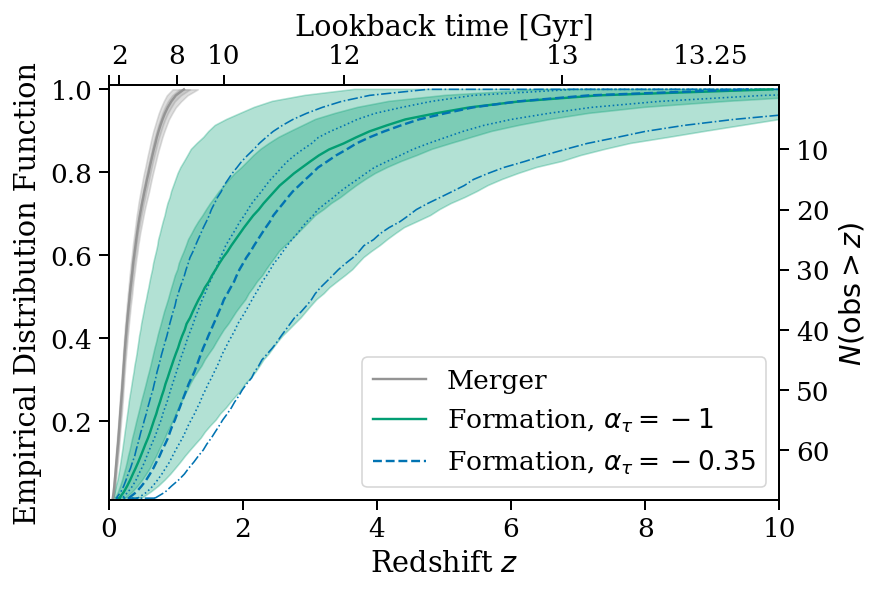

In [11]:
fig, ax = plt.subplots(constrained_layout = True)

lines_zm = plot_cdf_bands(ax, reweighted_PE_al01["redshift"], plot_kwargs = dict(label = 'Merger'), color = color_dict["merger"], ret_lines = True)

lines_zf_alpha1 = plot_cdf_bands(ax, cosmo_dict["z_at_lookback_time"](reweighted_PE_al01["formation_lookback_time"]), plot_kwargs = dict(label = r'Formation, $\alpha_\tau = -1$'), color = color_dict["default"], ret_lines = True)
lines_zf_alpha035 = plot_cdf_bands(ax, cosmo_dict["z_at_lookback_time"](reweighted_PE_al035["formation_lookback_time"]), plot_kwargs = dict(label = r'Formation, $\alpha_\tau = -0.35$', ls = '--'), filled = False, color = color_dict["shallower"], ret_lines = True)



ax.set_ylim(0.01,1.01)
ax.set_xlim(0, 10)

ax.set_xlabel("Redshift $z$")
ax.set_ylabel("Empirical Distribution Function")

plt.legend(loc = 'lower right')

timeax = ax.secondary_xaxis('top', functions=(cosmo_dict["lookback_time"], cosmo_dict["z_at_lookback_time"]))
timeax.set_xticks(ticks = [0, 2000, 8000, 10000, 12000, 13000, 13250], labels = ['', '2', '8', '10', '12', '13', '13.25'])

timeax.set_xlabel('Lookback time [Gyr]')

Ndetax = ax.secondary_yaxis('right', functions = (lambda x: (1 - x)*69, lambda x: 1 - x/69))
Ndetax.set_yticks(ticks = [10,20,30,40,50,60])

Ndetax.set_ylabel(r'$N(\mathrm{obs} > z)$')

#plt.savefig("figures/EDF_zmerge_zform_GWTC3.pdf", bbox_inches = 'tight')
#plt.savefig("figures/EDF_zmerge_zform_GWTC3.png", dpi = 300, bbox_inches = 'tight')

In [12]:
print('maximum merger redshift ', median_pm_symmetric(lines_zm[:,-1]))
print('maximum formation redshift, alpha = -1 ', median_pm_symmetric(lines_zf_alpha1[:,-1]))
print('maximum formation redshift, alpha = -0.35 ', median_pm_symmetric(lines_zf_alpha035[:,-1]))

maximum merger redshift  1.1^{+0.2}_{-0.2}
maximum formation redshift, alpha = -1  9.9^{+9.1}_{-6.2}
maximum formation redshift, alpha = -0.35  9.5^{+9.0}_{-4.8}


In [14]:
#how many events have formation redshifts above x?

n_above_3 = np.zeros(4000)

for i in range(4000):
    x = (1 + np.arange(69)[::-1])[lines_zf_alpha1[i,:] >= 3]
    if len(x) > 0:
        n_above_3[i] = x[0]

        
print(f"We have observed an event that formed above redshift 3 with credibility {1 - sum(n_above_3 == 0)/len(n_above_3)}")
print(f"The number of events that formed above redshift 3 is {median_pm_symmetric(n_above_3)}")



n_above_2 = np.zeros(4000)

for i in range(4000):
    x = (1 + np.arange(69)[::-1])[lines_zf_alpha1[i,:] >= 2]
    if len(x) > 0:
        n_above_2[i] = x[0]
        
print(f"We have observed an event that formed above redshift 2 with credibility {1 - sum(n_above_2 == 0)/len(n_above_2)}")
print(f"The number of events that formed above redshift 2 is {median_pm_symmetric(n_above_2)}")

n_above_1 = np.zeros(4000)

for i in range(4000):
    x = (1 + np.arange(69)[::-1])[lines_zf_alpha1[i,:] >= 1]
    if len(x) > 0:
        n_above_1[i] = x[0]
        
print(f"We have observed an event that formed above redshift 1 with credibility {1 - sum(n_above_1 == 0)/len(n_above_1)}")
print(f"The number of events that formed above redshift 1 is {median_pm_symmetric(n_above_1)}")
print(f"The number of events that formed above redshift 1 is greater than {np.percentile(n_above_1,10)}")



n_above_2_shallow = np.zeros(4000)

for i in range(4000):
    x = (1 + np.arange(69)[::-1])[lines_zf_alpha035[i,:] >= 2]
    if len(x) > 0:
        n_above_2_shallow[i] = x[0]

        
print(f"Shallow delay time: We have observed an event that formed above redshift 2 with credibility {1 - sum(n_above_2_shallow == 0)/len(n_above_2_shallow)}")
print(f"Shallow delay time: The number of events that formed above redshift 2 is {median_pm_symmetric(n_above_2_shallow)}")

n_above_3_shallow = np.zeros(4000)

for i in range(4000):
    x = (1 + np.arange(69)[::-1])[lines_zf_alpha035[i,:] >= 3]
    if len(x) > 0:
        n_above_3_shallow[i] = x[0]

        
print(f"Shallow delay time: We have observed an event that formed above redshift 3 with credibility {1 - sum(n_above_3_shallow == 0)/len(n_above_3_shallow)}")
print(f"Shallow delay time: The number of events that formed above redshift 3 is {median_pm_symmetric(n_above_3_shallow)}")

We have observed an event that formed above redshift 3 with credibility 0.976
The number of events that formed above redshift 3 is 13.0^{+24.0}_{-12.0}
We have observed an event that formed above redshift 2 with credibility 0.99575
The number of events that formed above redshift 2 is 24.0^{+26.0}_{-20.0}
We have observed an event that formed above redshift 1 with credibility 1.0
The number of events that formed above redshift 1 is 44.0^{+19.0}_{-29.0}
The number of events that formed above redshift 1 is greater than 21.0
Shallow delay time: We have observed an event that formed above redshift 2 with credibility 1.0
Shallow delay time: The number of events that formed above redshift 2 is 29.0^{+21.0}_{-17.0}
Shallow delay time: We have observed an event that formed above redshift 3 with credibility 0.9985
Shallow delay time: The number of events that formed above redshift 3 is 15.0^{+21.0}_{-11.0}


In [15]:
print("we have observed at least one event with z > ", np.percentile(lines_zf_alpha1[:,-1], 10), "with 90\% credibility")
print("we have observed at least two events with z > ", np.percentile(lines_zf_alpha1[:,-2], 10), "with 90\% credibility")
print("we have observed at least one event with z > ", np.percentile(lines_zf_alpha1[:,-1], 5), "with 95\% credibility")

we have observed at least one event with z >  4.44534158706665 with 90\% credibility
we have observed at least two events with z >  3.5264289855957034 with 90\% credibility
we have observed at least one event with z >  3.666985368728638 with 95\% credibility


### Formation rate as a function of redshift

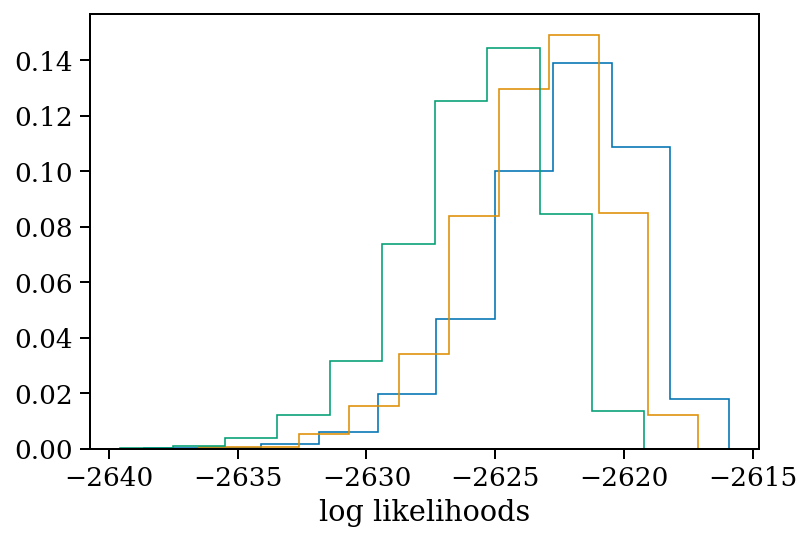

alpha = -1 max likelihood delay time model is favored to alpha = -0.7 by factor of  3.2772727
alpha = -1 max likelihood delay time model is favored to alpha = -0.35 by factor of  26.531172


In [16]:
plt.hist(loglikes, histtype = 'step', density = True)
plt.hist(loglikes_al07, histtype = 'step', density = True)
plt.hist(loglikes_al035, histtype = 'step', density = True)
plt.xlabel('log likelihoods')
plt.show()

print('alpha = -1 max likelihood delay time model is favored to alpha = -0.7 by factor of ', np.exp(max(loglikes)-max(loglikes_al07)))
print('alpha = -1 max likelihood delay time model is favored to alpha = -0.35 by factor of ',np.exp(max(loglikes)-max(loglikes_al035)))

In [17]:
def rate_age(T, a, b):
    '''
    T: age of the Universe.
    a: describes power law rise at early times
    b: describes characteristic timescale, exponential decay at late times (units: 1/time)
    returns: rate density as a function of age of the Universe T. Zero at T = 0.
    '''
    return jnp.where( T > 0, T**a * jnp.exp(-T * b), 0)


Ts = cosmo_dict["age_of_universe"] - tL_forms
SFR = 0.1 * rate_age(Ts/1e3, 1.34, 0.43) #in Msun Mpc^-3 yr^-1

SFR_UV = 0.037 * rate_age(Ts/1e3, 1.83, 0.48) #in Msun Mpc^-3 yr^-1

xs = cosmo_dict["z_at_lookback_time"](tL_forms)

SFR_MF = 0.01 * (1 + xs)**2.6 / (1 + ((1 +xs) / 3.2) ** 6.2) #in Msun Mpc^-3 yr^-1

In [18]:
from scipy.integrate import cumtrapz


frac_sfr_before_4 = np.interp(cosmo_dict["age_of_universe"] - cosmo_dict["lookback_time"](4.4), Ts[::-1], cumtrapz(SFR_UV[::-1], Ts[::-1], initial = 0)/cumtrapz(SFR_UV[::-1], Ts[::-1], initial = 0)[-1])

print(f"by z = 4.4, the Universe formed {frac_sfr_before_4} of its stars")

by z = 4.4, the Universe formed 0.04050425571221851 of its stars


### Figure 2: Inferred progenitor formation rate as a function of redshift

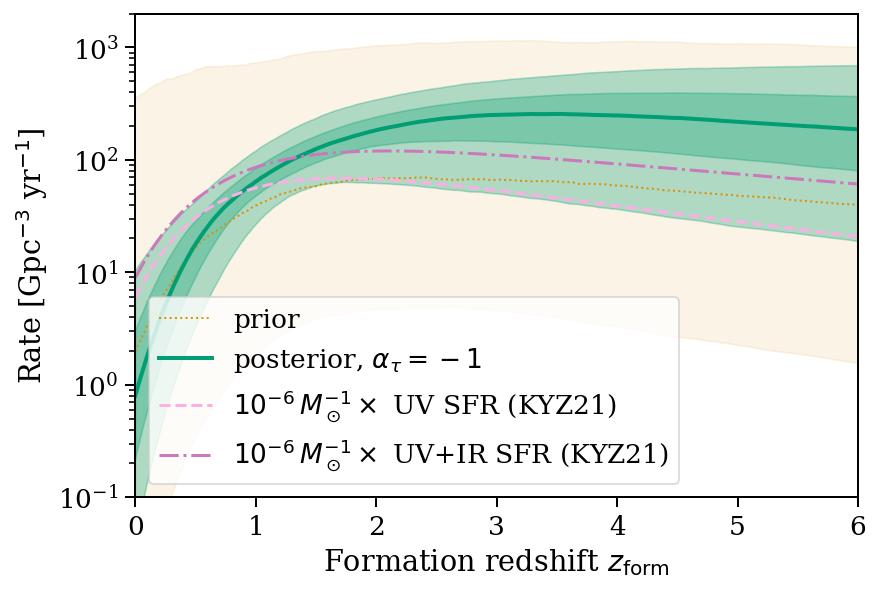

In [20]:

fig, ax = plt.subplots(constrained_layout=True)


plot_bands(ax, xs, 1e9 * Rfs_prior, bounds = [(5, 95)], plot_kwargs = dict(linewidth = 1.0, label = 'prior', ls = ':'), alpha = 0.1, color = color_dict["prior"])

plot_bands(ax, xs, 1e9 * Rfs, plot_kwargs = dict(linewidth = 2.0, label = r'posterior, $\alpha_\tau = -1$'), color = color_dict["default"])

ax.plot(xs, 1e9 * 1e-6 * SFR_UV, ls = '--', color = sns.color_palette()[6], linewidth = 1.5, label = r'$10^{-6}\,M_\odot^{-1}\times$ UV SFR (KYZ21)')

ax.plot(xs, 1e9 * 1e-6 * SFR, ls = '-.', color = sns.color_palette()[4], linewidth = 1.5, label = r'$10^{-6}\,M_\odot^{-1}\times$ UV+IR SFR (KYZ21)')

ax.set_yscale('log')

ax.set_xlim(0, 6)

ax.set_ylim(1e-1, 2e3)

ax.set_xlabel('Formation redshift $z_\mathrm{form}$')

ax.set_ylabel('Rate [Gpc$^{-3}$ yr$^{-1}$]')

plt.legend(loc = 'lower left')


#plt.savefig('figures/Rate_form_v_z_default_tau_withUV.pdf', bbox_inches = 'tight')

#plt.savefig('figures/Rate_form_v_z_default_tau_withUV.png', dpi = 300, bbox_inches = 'tight')

### Figure 3: Formation effiency as a function of redshift

Text(0, 0.5, '$\\mathrm{d}N_\\mathrm{BBH}/ \\mathrm{d}M_\\mathrm{SF}\\, [M_\\odot^{-1}]$')

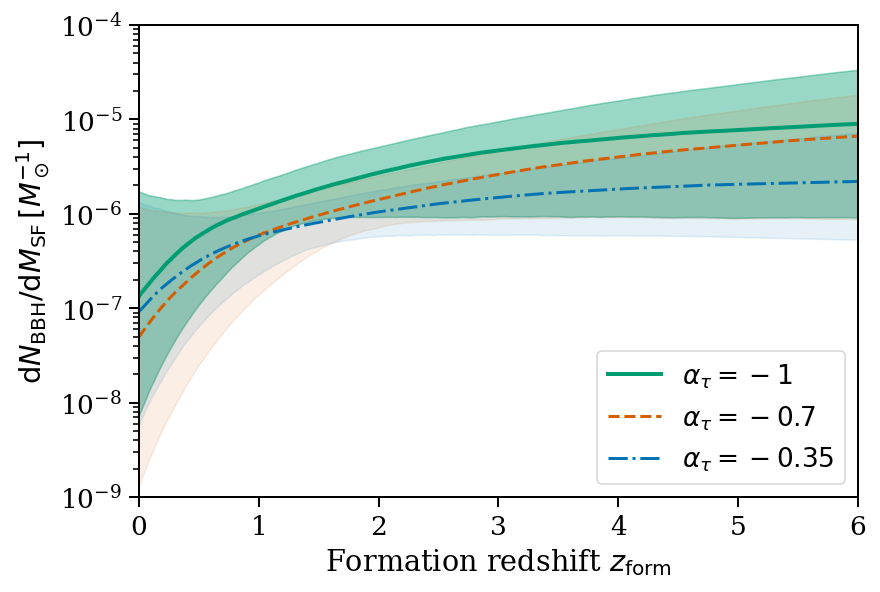

In [21]:
efficiency_default = Rfs / SFR_UV

efficiency_shallow = Rfs_al07 / SFR_UV

efficiency_shallower = Rfs_al035 / SFR_UV

fig, ax = plt.subplots(constrained_layout=True)

plot_bands(ax, xs, efficiency_default, bounds = [(5, 95)], plot_kwargs = dict(linewidth = 2.0, label = r'$\alpha_\tau = -1$'), alpha = 0.4, color = color_dict["default"])

plot_bands(ax, xs, efficiency_shallow, bounds = [(5, 95)], plot_kwargs = dict(linewidth = 1.5, label = r'$\alpha_\tau = -0.7$', ls = '--'), alpha = 0.1, color = color_dict["shallow"])

plot_bands(ax, xs, efficiency_shallower, bounds = [(5, 95)], plot_kwargs = dict(linewidth = 1.5, label = r'$\alpha_\tau = -0.35$', ls = '-.'), alpha = 0.1, color = color_dict["shallower"])


plt.legend(loc = 'lower right')

ax.set_yscale('log')

ax.set_xlim(0,6)

ax.set_ylim(1e-9, 1e-4)

ax.set_xlabel('Formation redshift $z_\mathrm{form}$')

ax.set_ylabel(r'$\mathrm{d}N_\mathrm{BBH}/ \mathrm{d}M_\mathrm{SF}\, [M_\odot^{-1}]$')

#plt.savefig('figures/formation_efficiency_v_redshift_different_tau.pdf', bbox_inches = 'tight')
#plt.savefig('figures/formation_efficiency_v_redshift_different_tau.png', bbox_inches = 'tight', dpi = 300)

In [22]:
print('default delay time, efficiency at z = 0', median_pm_symmetric(efficiency_default[:,0]*1e8))

z3_ind = np.arange(len(xs))[xs>=3][0]
print('default delay time, efficiency at z = 3', median_pm_symmetric(efficiency_default[:,z3_ind]*1e6))

z4_ind = np.arange(len(xs))[xs>=4][0]
print('default delay time, efficiency at z = 4', median_pm_symmetric(efficiency_default[:,z4_ind]*1e6))

default delay time, efficiency at z = 0 13.4^{+157.2}_{-12.7}
default delay time, efficiency at z = 3 4.7^{+4.8}_{-3.8}
default delay time, efficiency at z = 4 6.4^{+9.4}_{-5.5}


### Figure 5: Metallicity evolution

In [23]:
def yield_logZ(A, B, logZ):
    '''BBH yield as a function of log10 metallicity'''
    
    return np.where(logZ < (B - 1), A * np.log(B - logZ), 0)

def yield_muZ(A, BminusM, sig):
    '''BBH yield marginalized over distribution of metallicities
    as a function of parameter B - mean, where mean is the mean log10metallicity'''
    
    x = np.linspace(1, 10, 10000)
    
    integrand = np.exp(-(BminusM - x)**2/(2*sig**2)) * np.log(x)
    
    return A/(sig * (2*np.pi)**0.5) * np.trapz(integrand, x) 

BmM = np.linspace(-2, 5, 1000) #mu between roughly -4 < mu < 3, definitely within where we expect

sig = 0.1
yield_BmM_sig01 = np.array([yield_muZ(1, x, sig) for x in BmM]) #fixing A = 1

sig = 0.2
yield_BmM_sig02 = np.array([yield_muZ(1, x, sig) for x in BmM]) #fixing A = 1


sig = 0.4
yield_BmM_sig04 = np.array([yield_muZ(1, x, sig) for x in BmM]) #fixing A = 1


yield_BmMs = {'01' : yield_BmM_sig01, '02' : yield_BmM_sig02, '04' : yield_BmM_sig04}


def mean_metallicity_given_yield(A, B, eta, sig = '02'):
    
    
    BminusM = np.interp(eta / A, yield_BmMs[sig], BmM)
    
    mu = B - BminusM
    
    return mu

In [24]:
#from Chruślińska+ 2021 https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.4994C/abstract, Fig 7 left and right panels.
#see https://ftp.science.ru.nl/astro/mchruslinska for data files.
with h5py.File("/Users/mayafishbach/Downloads/SFRD_Z_z_data/peakZ302f14SBBoco_FMR270_FOH_z_dM.dat.h5", "r") as inp:
    z_plot = np.array(inp["redshift"])
    peakZ_left = np.array(inp["peak_metallicity"])
    
with h5py.File("/Users/mayafishbach/Downloads/SFRD_Z_z_data/peakZ204f14SBBoco_FMR270_FOH_z_dM.dat.h5", "r") as inp:
    z_plot = np.array(inp["redshift"])
    peakZ_right = np.array(inp["peak_metallicity"])

In [25]:
peakZ_Zsun_left = peakZ_left - 8.93 #converting to log10 solar metallicity assuming Grevesse & Sauval 1998 scale
peakZ_Zsun_right = peakZ_right - 8.93 

In [26]:
As = dict(medium = 3.5e-5, low = 1e-5, high = 6e-5) #medium, low and high efficiency
Bs = dict(medium = 0.85, low = 0.4, high = 1.3)

efficiencies = dict(default = efficiency_default, shallow = efficiency_shallow, shallower = efficiency_shallower) #default, shallow and shallower delay time dists
mean_Zs = dict(default = dict(), shallow = dict(), shallower = dict()) 

for key_tau in mean_Zs.keys():
    for key_Z in As.keys():
        mean_Zs[key_tau][key_Z] = mean_metallicity_given_yield(As[key_Z], Bs[key_Z], efficiencies[key_tau], sig = '02')

In [27]:
print('default delay time, mean log10 metallicity at z = 0', median_pm_symmetric(mean_Zs["default"]["medium"][:,0]))

z3_ind = np.arange(len(xs))[xs>=3][0]
print('default delay time, mean log10 metallicity at z = 3', median_pm_symmetric(mean_Zs["default"]["medium"][:,z3_ind]))

z4_ind = np.arange(len(xs))[xs>=4][0]
print('default delay time, mean log10 metallicity at z = 4', median_pm_symmetric(mean_Zs["default"]["medium"][:,z4_ind]))



default delay time, mean log10 metallicity at z = 0 0.2^{+0.2}_{-0.3}
default delay time, mean log10 metallicity at z = 3 -0.3^{+0.3}_{-0.2}
default delay time, mean log10 metallicity at z = 4 -0.3^{+0.3}_{-0.4}


In [28]:
print('alpha = -0.35 delay time, mean log10 metallicity at z = 0', median_pm_symmetric(mean_Zs["shallower"]["medium"][:,0]))

z3_ind = np.arange(len(xs))[xs>=3][0]
print('alpha = -0.35 delay time, mean log10 metallicity at z = 3', median_pm_symmetric(mean_Zs["shallower"]["medium"][:,z3_ind]))

z4_ind = np.arange(len(xs))[xs>=4][0]
print('alpha = -0.35 delay time, mean log10 metallicity at z = 4', median_pm_symmetric(mean_Zs["shallower"]["medium"][:,z4_ind]))




alpha = -0.35 delay time, mean log10 metallicity at z = 0 0.2^{+0.2}_{-0.3}
alpha = -0.35 delay time, mean log10 metallicity at z = 3 -0.1^{+0.1}_{-0.1}
alpha = -0.35 delay time, mean log10 metallicity at z = 4 -0.1^{+0.1}_{-0.1}


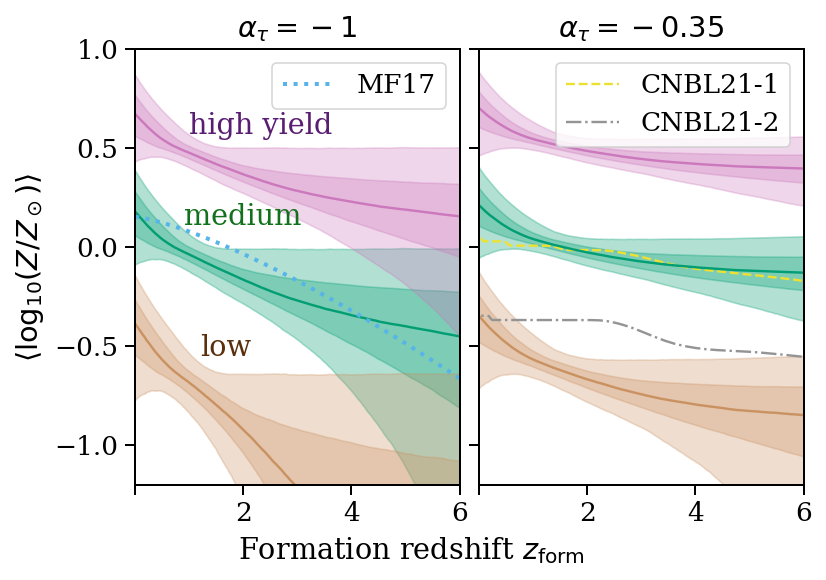

In [29]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, sharex = True, sharey = True)

cs = dict(medium = sns.color_palette()[2], low = sns.color_palette()[5], high = sns.color_palette()[4],
         default = sns.color_palette()[2], shallow = sns.color_palette()[3], shallower = sns.color_palette()[0])

cs_dark = dict(medium = sns.color_palette("dark")[2], low = sns.color_palette("dark")[5], high = sns.color_palette("dark")[4],
         default = sns.color_palette("dark")[2], shallow = sns.color_palette("dark")[3], shallower = sns.color_palette("dark")[0])

labels = dict(medium = 'medium yield', low = 'low yield', high = 'high yield',
             default = r'$\alpha_\tau = -1$', shallow = r'$\alpha_\tau = -0.5$', shallower = r'$\alpha_\tau = -0.25$')

for key_Z in As.keys():
    plot_bands(ax[0], xs, mean_Zs["default"][key_Z], color = cs[key_Z])


logZ_of_z_mean = 0.153 - 0.074 * xs**1.34 #logmean metallicity as a function of redshift from Madau & Fragos 2017

ax[0].plot(xs, logZ_of_z_mean, ls = ':', linewidth = 2.0, color = sns.color_palette()[9], label = 'MF17')
ax[1].plot(z_plot, peakZ_Zsun_left, ls = '--', color = sns.color_palette()[8], label = 'CNBL21-1') 
ax[1].plot(z_plot, peakZ_Zsun_right, ls = '-.', color = sns.color_palette()[7], label = 'CNBL21-2') 




ax[0].set_xlim(0,6)
ax[0].set_ylim(-1.2, 1)

#ax[0].set_xlabel('Formation redshift $z_\mathrm{form}$')
ax[0].set_ylabel(r'$\langle \log_{10}(Z/Z_\odot) \rangle$') 

ax[0].set_title(r'$\alpha_\tau = -1$')

ax[1].set_title(r'$\alpha_\tau = -0.35$')

for key_Z in As.keys():
    plot_bands(ax[1], xs, mean_Zs["shallower"][key_Z], color = cs[key_Z])


ax[0].annotate(text = "high yield", xy = (1, 0.57), color = cs_dark["high"])
ax[0].annotate(text = "medium", xy = (0.9, 0.11), color = cs_dark["medium"])
ax[0].annotate(text = "low", xy = (1.2, -0.55), color = cs_dark["low"])

ax[0].legend(loc = 'upper right')
ax[1].legend(loc = 'upper right')

ax[1].set_xticks([0,2,4,6], labels = ['','2', '4', '6'])

fig.text(0.5, -0.001, 'Formation redshift $z_\mathrm{form}$', ha = 'center')

plt.tight_layout(w_pad = 0.05)

#plt.savefig("figures/meanZvz_2panel.pdf", bbox_inches = 'tight')
#plt.savefig("figures/meanZvz_2panel.png", dpi = 300, bbox_inches = 'tight')